**Imports:**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

**Reading in the data:**

In [2]:
df = pd.read_csv('Crime_Data_from_2020_to_Present.csv')

In [3]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [4]:
# Handle missing data
df = df.dropna(subset=['Part 1-2', 'DATE OCC', 'TIME OCC', 'Vict Age', 'Vict Sex', 'Vict Descent', 'LAT', 'LON', 'Weapon Used Cd'])

In [5]:
# Convert 'DATE OCC' to a datetime object
df['DATE OCC'] = df['DATE OCC'].astype(str)
df['DATE OCC'] = df['DATE OCC'].str[:-5]
df['DATE OCC datetime'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%y')

In [6]:
# Convert 'TIME OCC' to time and extract hours
df['TIME OCC'] = df['TIME OCC'].astype(str)
df = df[df['TIME OCC'].str.len() != 1]
def convert_time(time_str):
    time_str = time_str.zfill(4)
    return f"{time_str[:2]}:{time_str[2:]}"

# Apply the function to the 'TIME OCC' column
df['TIME OCC'] = df['TIME OCC'].apply(convert_time)
df['TIME OCC'] = pd.to_datetime(df['TIME OCC'], format='%H:%M')
df['Hour'] = df['TIME OCC'].dt.hour

In [7]:
df['Month'] = df['DATE OCC datetime'].dt.month
df['Year'] = df['DATE OCC datetime'].dt.year
df['Day'] = df['DATE OCC datetime'].dt.day
df['time_continuous'] = df['Year']+df['Month']/12

df[['DATE OCC','Hour','TIME OCC', 'DATE OCC datetime', 'Month', 'Year', 'Day','time_continuous']]

,DATE OCC,Hour,TIME OCC,DATE OCC datetime,Month,Year,Day,time_continuous
9,12/31/20,12,1900-01-01 12:20:00,2020-12-31,12,2020,31,2021.000000
12,2/1/20,8,1900-01-01 08:00:00,2020-02-01,2,2020,1,2020.166667
13,4/11/20,12,1900-01-01 12:00:00,2020-04-11,4,2020,11,2020.333333
19,11/27/20,18,1900-01-01 18:00:00,2020-11-27,11,2020,27,2020.916667
24,3/15/20,12,1900-01-01 12:00:00,2020-03-15,3,2020,15,2020.250000
...,...,...,...,...,...,...,...,...
901333,8/27/23,0,1900-01-01 00:30:00,2023-08-27,8,2023,27,2023.666667
901339,7/24/23,14,1900-01-01 14:00:00,2023-07-24,7,2023,24,2023.583333
901347,12/14/23,11,1900-01-01 11:05:00,2023-12-14,12,2023,14,2024.000000
901350,7/8/23,12,1900-01-01 12:30:00,2023-07-08,7,2023,8,2023.583333


## Comments

Prepare data; grouped by Month and Year to get the number of crimes committed every month of every year.
Time continuous is a continuous version on the dates, makes it convenient to use as feature. But we only use this in the first linear model, not relevant for the final model.
Also, I removed 2020 and 2024. 2020 because Covid had huge effects on crime reports and 2024 becaue it is an inclomplete year. Later we use our final model to predict the crime count for 2024.

In [8]:
#Prepare data for linear regression
#Filter out year 2020 and 2024
#Group by year and month to get total crimes each month
df_date = df.groupby(['Year','Month']).size().reset_index(name='crime_count')
df_date = df_date[(df_date['Year']>= 2021)&(df_date['Year']<= 2023)]
df_date['time_continuous'] = df_date['Year']+df_date['Month']/12
df_date['Date'] = pd.to_datetime(df_date['Year'].astype(str) + '-' + df_date['Month'].astype(str), format='%Y-%m')
df_date.head(10)


,Year,Month,crime_count,time_continuous,Date
12,2021,1,5608,2021.083333,2021-01-01
13,2021,2,5153,2021.166667,2021-02-01
14,2021,3,5531,2021.250000,2021-03-01
15,2021,4,5578,2021.333333,2021-04-01
16,2021,5,6032,2021.416667,2021-05-01
17,2021,6,6163,2021.500000,2021-06-01
18,2021,7,6917,2021.583333,2021-07-01
19,2021,8,6705,2021.666667,2021-08-01
20,2021,9,6476,2021.750000,2021-09-01
21,2021,10,6674,2021.833333,2021-10-01


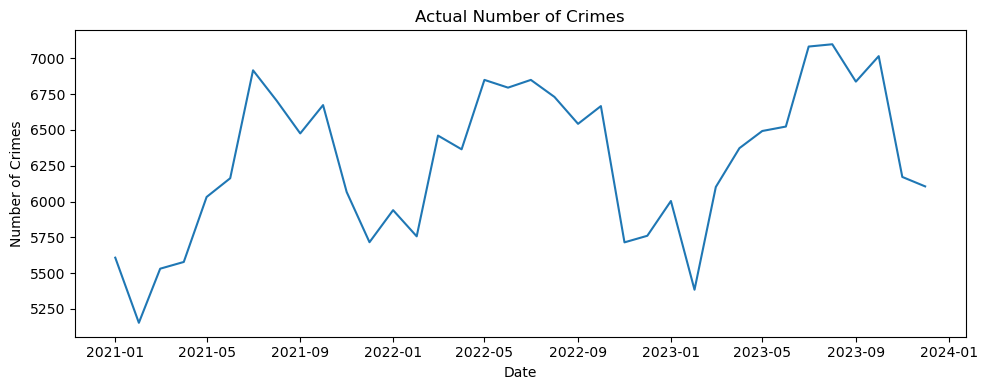

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(df_date['Date'], df_date['crime_count'])

plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.title('Actual Number of Crimes')
plt.tight_layout()
plt.show()
plt.gcf().autofmt_xdate()

## Discussion

We aim to make predictions of the number of crimes based on the records we have.
First I tried to use a linear regression to predict crime count using time continuous as a the only feature.
Not good, R^2 very bad, this was the baseline and we improve the model from here.

## Linear Fit

In [10]:
#Time continuous as the only feature
X = df_date[['time_continuous']]
y = df_date['crime_count']

# Add a constant term to the feature matrix X
X = sm.add_constant(X)

# Fit linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     6.385
Date:                Sat, 11 May 2024   Prob (F-statistic):             0.0163
Time:                        12:48:12   Log-Likelihood:                -272.84
No. Observations:                  36   AIC:                             549.7
Df Residuals:                      34   BIC:                             552.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -4.73e+05    1.9e+05     

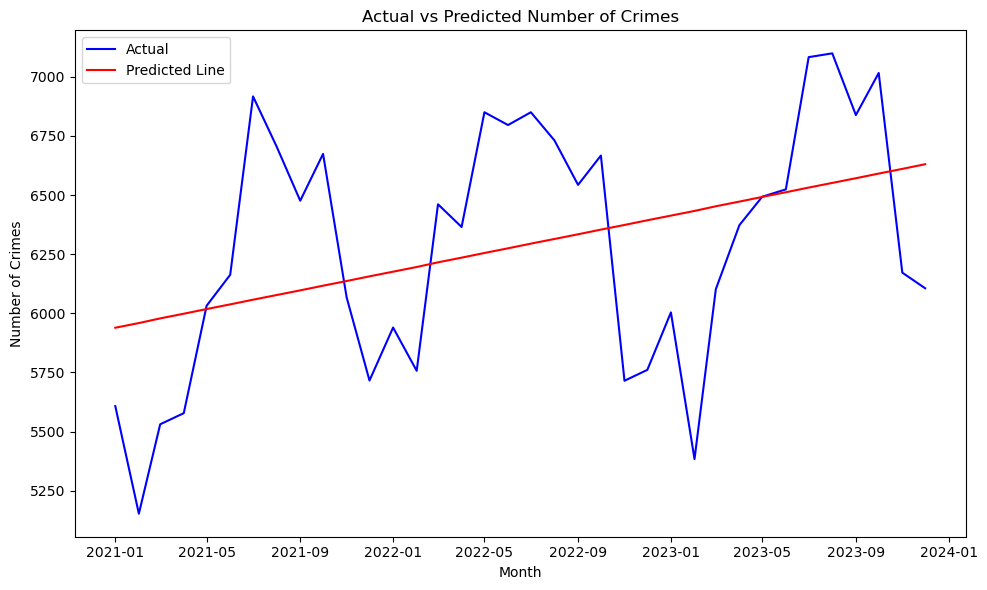

In [11]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

plt.plot(df_date['Date'], df_date['crime_count'], color='blue', label='Actual')

# Plot predicted line
plt.plot(df_date['Date'], model.predict(X), color='red', label='Predicted Line')

plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Actual vs Predicted Number of Crimes')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#Sum of squared errors
squared_errors = (df_date['crime_count'] - model.predict(X)) ** 2
sum_squared_errors = squared_errors.sum()
log_sum_squared_errors = np.log10(sum_squared_errors)
log_sum_squared_errors

6.906823511616603

## Comments

No we make predictions of the number of crimes by using year and months as categorical variables.
R^2 improved by a lot. But we can do better so I tried another model.

## Linear Fit Using Month as Categorical Variable

In [13]:
# Make a copy of the original DataFrame
df_date_copy = df_date.copy()

model1 = smf.ols('crime_count ~ Year + C(Month)', data = df_date_copy).fit()

# Print the summary of the model
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     12.38
Date:                Sat, 11 May 2024   Prob (F-statistic):           2.49e-07
Time:                        12:48:12   Log-Likelihood:                -239.77
No. Observations:                  36   AIC:                             505.5
Df Residuals:                      23   BIC:                             526.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.795e+05   9.76e+04     -3.

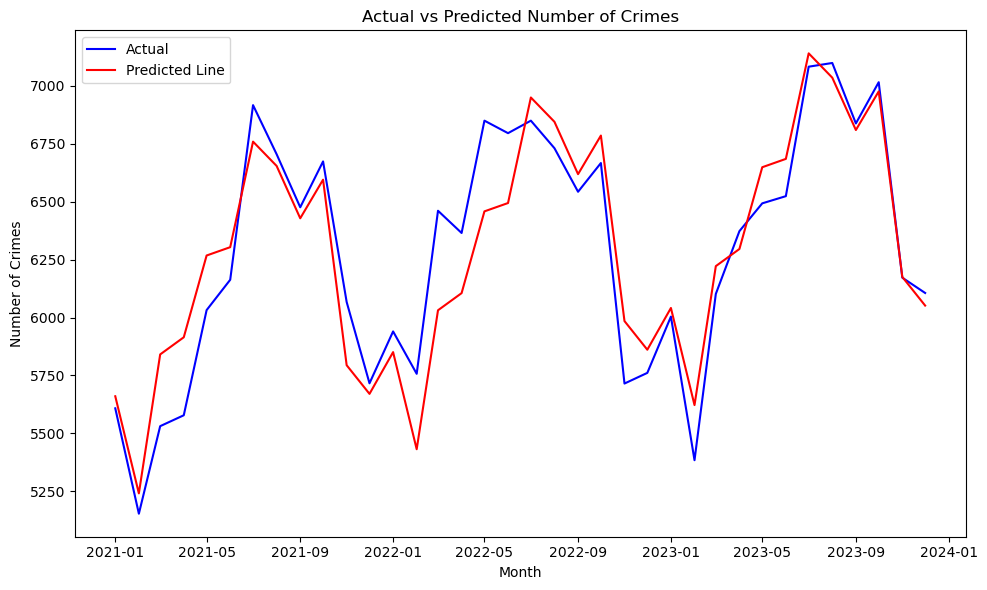

In [14]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

plt.plot(df_date_copy['Date'], df_date_copy['crime_count'], color='blue', label='Actual')

# Plot predicted line
plt.plot(df_date_copy['Date'], model1.predict(df_date_copy), color='red', label='Predicted Line')

plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Actual vs Predicted Number of Crimes')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
#Sum of squared errors
squared_errors = (df_date_copy['crime_count'] - model1.predict(df_date_copy
                                                              )) ** 2
sum_squared_errors = squared_errors.sum()
log_sum_squared_errors = np.log10(sum_squared_errors)
log_sum_squared_errors

6.10885755533655

## Comments

Final model using year, months as categorical values, and leagged values (only 1 lag) as features.
(using 2 lags gave a worst R^2 so I kept it at only 1 lag)
R^2 is great and sum of squared erros went down.

## Linear Fit Using Month as Categorical Variable and Lagged Values

In [16]:
# Make a copy of the original DataFrame

df_date_copy = df_date.copy()

df_date_copy = df_date_copy.sort_values(by='Date', ascending=False)

df_lag = df_date_copy.copy().iloc[:-1]
df_lag['Lag1'] = df_date_copy['crime_count'].values[1:]

model2 = smf.ols('crime_count ~ Year + Lag1 + C(Month)', data = df_lag).fit()

# #Print the summary of the model
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     20.69
Date:                Sat, 11 May 2024   Prob (F-statistic):           4.48e-09
Time:                        12:48:12   Log-Likelihood:                -221.94
No. Observations:                  35   AIC:                             471.9
Df Residuals:                      21   BIC:                             493.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.132e+05   9.55e+04     -1.

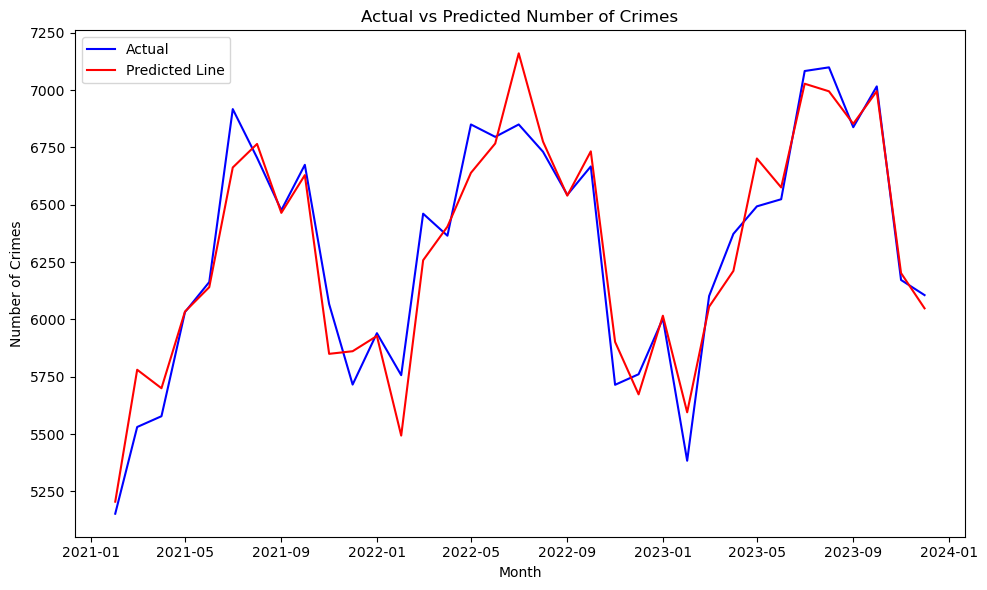

In [17]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

plt.plot(df_lag['Date'], df_lag['crime_count'], color='blue', label='Actual')

# Plot predicted line
plt.plot(df_lag['Date'], model2.predict(df_lag), color='red', label='Predicted Line')

plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Actual vs Predicted Number of Crimes')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
#Sum of squared errors
squared_errors = (df_lag['crime_count'] - model2.predict(df_lag)) ** 2
sum_squared_errors = squared_errors.sum()
log_sum_squared_errors = np.log10(sum_squared_errors)
log_sum_squared_errors

5.819527299359646

## Comments

There is a graph showing actual vs predicted for the three year and sparate graphs for each year below.
The 2021 graphs starts at Feb because of the lag1 being used
(TA said it was fine)

## Breakdown of prediction by month and year

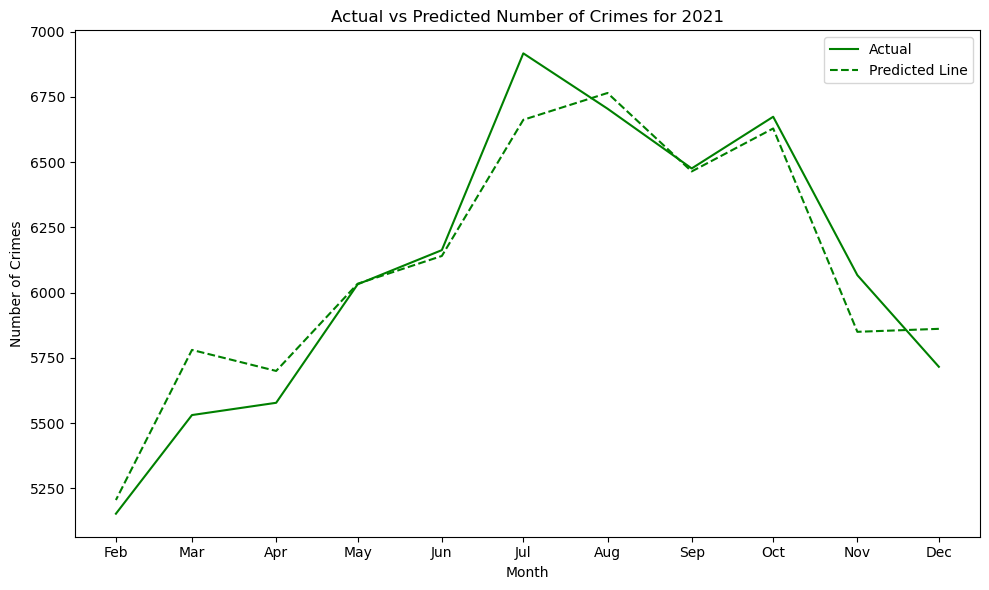

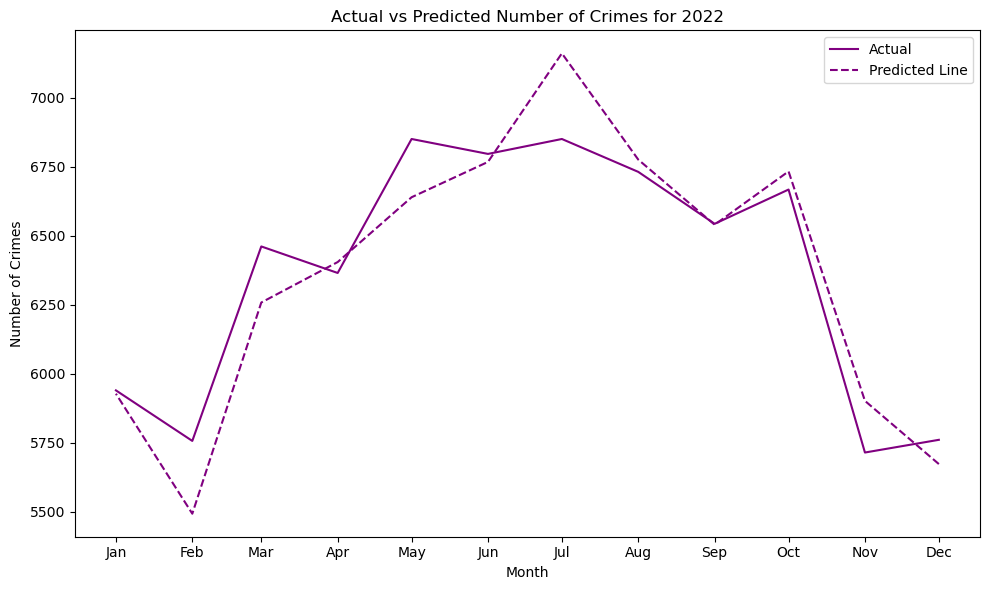

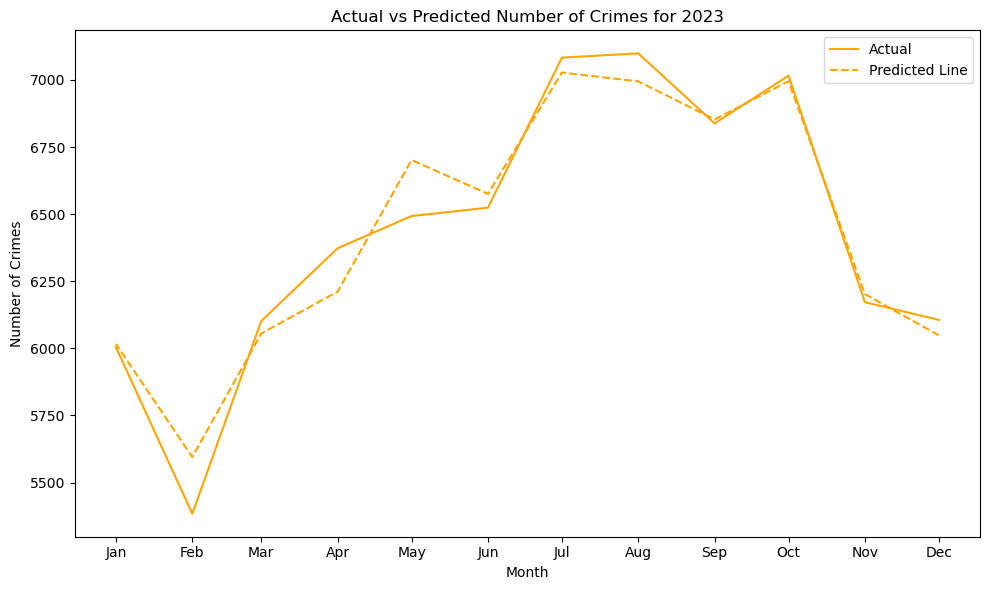

In [19]:
for year, color in zip(range(2021, 2024), ['green', 'purple', 'orange']):
    df_year = df_lag[df_lag['Date'].dt.year == year]
    
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    
    plt.plot(df_year['Date'], df_year['crime_count'], color=color, label='Actual')
    
    plt.plot(df_year['Date'], model2.predict(df_year), color=color, linestyle='--', label='Predicted Line')
    
    plt.xlabel('Month')
    plt.ylabel('Number of Crimes')
    plt.title(f'Actual vs Predicted Number of Crimes for {year}')
    plt.legend()
    
    # Set x-axis ticks to be each month
    plt.xticks(df_year['Date'], [month.strftime('%b') for month in df_year['Date']])
    
    plt.tight_layout()
    plt.show()


## Make prediction for 2024

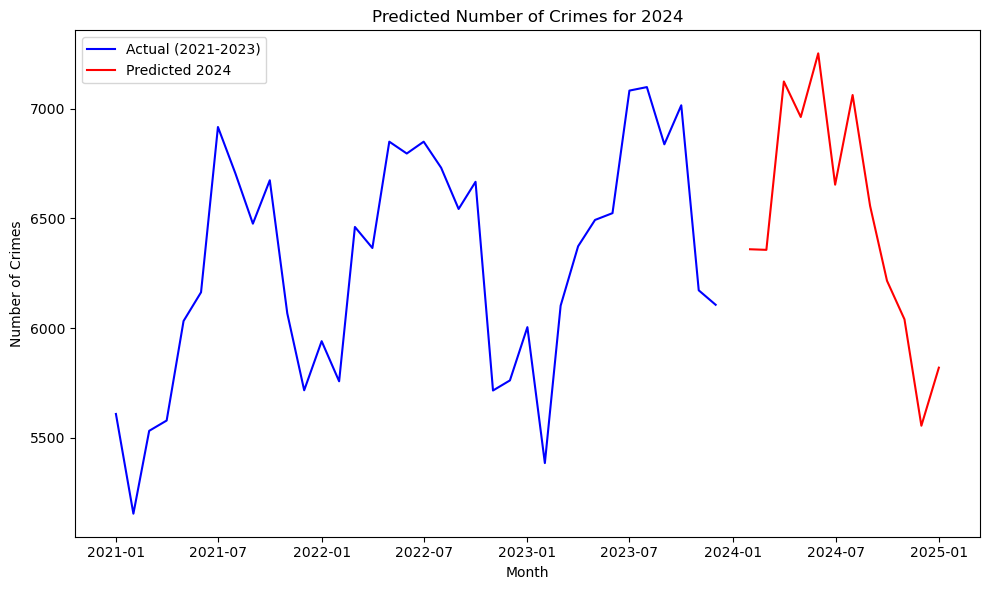

In [20]:
import pandas as pd
import statsmodels.formula.api as smf

# Assuming df_date_copy contains your original data

# Create a DataFrame for 2024 with consistent month levels
months_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='M')
df_2024 = pd.DataFrame({'Date': months_2024})
df_2024['Year'] = df_2024['Date'].dt.year
df_2024['Month'] = df_2024['Date'].dt.month  # Use numeric months for consistency

# Calculate lagged values for 2024
df_lag_2024 = df_2024.copy()
df_lag_2024['Lag1'] = df_date_copy['crime_count'].values[1:13]

# Predict using the model with categorical variables
predictions_2024 = model2.predict(df_lag_2024)

# Plot actual vs predicted for 2024
plt.figure(figsize=(10, 6))
plt.plot(df_date_copy['Date'], df_date_copy['crime_count'], color='blue', label='Actual (2021-2023)')
plt.plot(df_2024['Date'], predictions_2024, color='red', label='Predicted 2024')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Predicted Number of Crimes for 2024')
plt.legend()
plt.tight_layout()
plt.show()


## Comments

Graph above shows the actual levels of crimes from 2021 to 2023 and the red is the predicted crime using the model.
We can see that the model is able to predict seasonal variations.
The graph below is only the predictions for 2024
Reference discussion 12 and lecture 23 for more context on forecasting

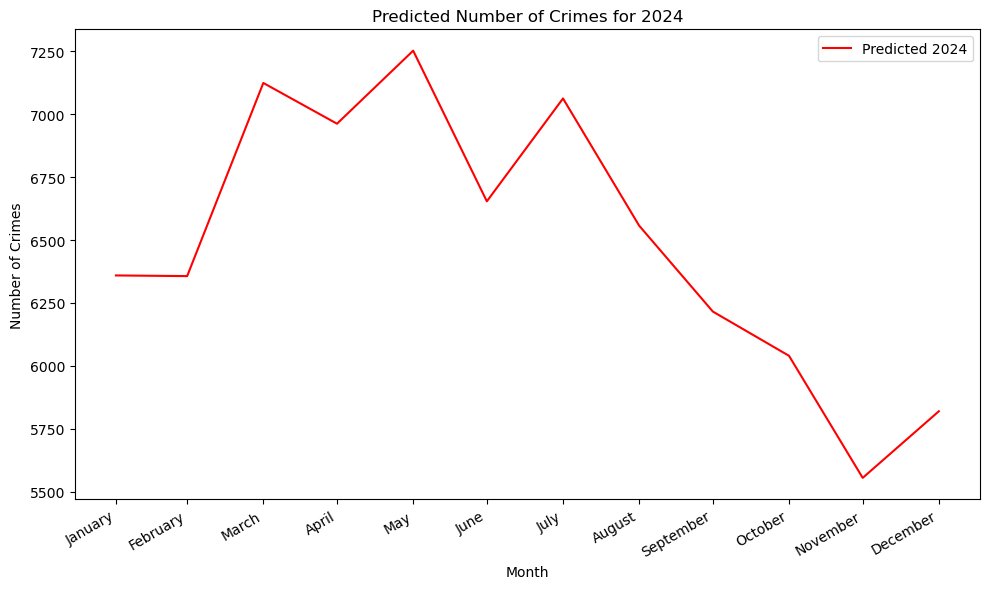

In [21]:
import pandas as pd
import statsmodels.formula.api as smf

# Assuming df_date_copy contains your original data

# Create a DataFrame for 2024 with consistent month levels
months_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='M')
df_2024 = pd.DataFrame({'Date': months_2024})
df_2024['Year'] = df_2024['Date'].dt.year
df_2024['Month'] = df_2024['Date'].dt.month  # Use numeric months for consistency

# Calculate lagged values for 2024
df_lag_2024 = df_2024.copy()
df_lag_2024['Lag1'] = df_date_copy['crime_count'].values[1:13]

# Predict using the model with categorical variables
predictions_2024 = model2.predict(df_lag_2024)

# Plot actual vs predicted for 2024
plt.figure(figsize=(10, 6))

plt.plot(df_2024['Date'], predictions_2024, color='red', label='Predicted 2024')
plt.xticks(df_2024['Date'], df_2024['Date'].dt.strftime('%B'))
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Predicted Number of Crimes for 2024')
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()